In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Hanoi_Census_2020.csv').loc[:, 'district':]
df.head()

,district,district_id,ward,ward_id,ward_level,area,pop_density,population,children_0_14,female_15_54,male_15_59,elders,no_household,no_household_w_home
0,Quan Ba Dinh,1,Phuong Phuc Xa,1,Phuong,0.894,24.562,"21,946","1,238","7,796","8,321","4,591","5,863","5,855"
1,Quan Ba Dinh,1,Phuong Truc Bach,4,Phuong,0.506,13.962,"7,065",320,"2,301","2,475","1,969","1,948","1,948"
2,Quan Ba Dinh,1,Phuong Vinh Phuc,6,Phuong,0.715,33.376,"23,867","1,486","8,557","8,997","4,827","6,314","6,298"
3,Quan Ba Dinh,1,Phuong Cong Vi,7,Phuong,0.538,29.723,"15,979",856,"5,577","5,983","3,563","4,357","4,349"
4,Quan Ba Dinh,1,Phuong Lieu Giai,8,Phuong,0.681,30.974,"21,084","1,153","7,400","7,819","4,712","5,639","5,637"


### Feature Selection

Hanoi's ward will be clustered based on:
- Population density
- Average number of people per household
- Percentage of children
- Percentage of people in labor age
- Percentage of elders

Those features are comparative and have meaningful insights for ward comparison when clustering

## 1. Data Transformation

* Convert string of number to integer

In [3]:
for i in df.loc[:, 'population':].columns:
    df[i] = df[i].str.replace(',', '')
    
df.loc[:, 'population':] = df.loc[:, 'population':].astype(int)

- Convert age groups: children, people in labor age and elders to percentage format of population

In [4]:
for i in range(8, 12, 1):
    df.iloc[:, i] = df.iloc[:, i] / df['population']
    
df['labor_age'] = df['female_15_54'] + df['male_15_59']

* Calculate number of people per household and delete unnecessary columns

In [ ]:
df['average_household'] = df['population'] / df['no_household']
df = df.drop(columns=['district_id', 'ward_level', 'area','population', 'female_15_54', 'male_15_59', 'no_household_w_home', 'no_household'])
df.head()

In [6]:
df.describe()

,ward_id,pop_density,children_0_14,elders,labor_age,average_household
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,6013.228522,8.694644,0.238462,0.200084,0.580560,3.728824
std,4729.798802,14.566439,0.043013,0.070906,0.059970,0.374434
min,1.000000,0.090000,0.044301,0.080214,0.283097,2.325817
25%,427.750000,1.282500,0.224744,0.148889,0.568851,3.487877
50%,9629.500000,2.171000,0.248083,0.176753,0.582293,3.718831
75%,10068.250000,6.183000,0.264924,0.257407,0.597792,3.972499
max,10504.000000,95.108000,0.321214,0.461146,0.786440,5.008977


## 2. Standardize data

Data are standardized to have the standard deviation = 1 and mean = 0 so that data are comparable

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = df.loc[:, 'pop_density':].columns
X = df[features]
scaler.fit(X)
X_scaled = scaler.transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=features, index=df.index)
df_scaled

,pop_density,children_0_14,elders,labor_age,average_household
0,1.090246,-4.236126,0.128607,2.567370,0.038252
1,0.361920,-4.494818,1.109658,1.592968,-0.272719
2,1.695856,-4.099990,0.030512,2.585712,0.136826
3,1.444859,-4.302230,0.323185,2.384723,-0.164102
4,1.530815,-4.276269,0.330339,2.357644,0.027095
...,...,...,...,...,...
577,-0.538868,0.132479,-0.457949,0.127577,-0.425968
578,-0.549312,0.586281,-0.764480,0.164523,-0.625972
579,-0.529249,0.490489,-0.834004,0.315429,0.382820
580,-0.521416,0.639348,-0.866755,0.247386,1.252076


## 3. Principal Components Analysis

From 5 features, we combine into 2 features, which makes the clustering algorithm more efficient and easy to visualize

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['first_pc', 'second_pc'], index=df.index)
df_pca.head()

,first_pc,second_pc
0,4.271899,-0.023395
1,3.587012,1.239137
2,4.491955,-0.056756
3,4.463703,0.348572
4,4.409063,0.330299


## 4. Build clustering

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### Elbow test

I use Elbow test to find the most appropriate number of clusters. I will try two methods: Distortion and Inertia

In [10]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)
 
    distortions.append(np.sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = np.sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

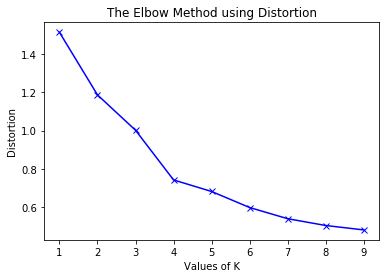

In [11]:
# It is calculated as the average of the squared distances from the cluster centers of the respective clusters. 
# Typically, the Euclidean distance metric is used.

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

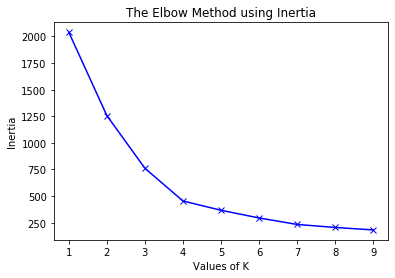

In [12]:
# It is the sum of squared distances of samples to their closest cluster center.

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Build clustering with k = 4

In [ ]:
kmeanModel = KMeans(n_clusters=4).fit(df_pca)
df_pca['kmean_group'] = kmeanModel.labels_
df_pca

In [14]:
df['kmean_group'] = df_pca['kmean_group']
df[['first_pc', 'second_pc']] = df_pca[['first_pc', 'second_pc']]
df.head()

,district,ward,ward_id,pop_density,children_0_14,elders,labor_age,average_household,kmean_group,first_pc,second_pc
0,Quan Ba Dinh,Phuong Phuc Xa,1,24.562,0.056411,0.209195,0.734394,3.743135,0,4.271899,-0.023395
1,Quan Ba Dinh,Phuong Truc Bach,4,13.962,0.045294,0.278698,0.676008,3.626797,0,3.587012,1.239137
2,Quan Ba Dinh,Phuong Vinh Phuc,6,33.376,0.062262,0.202246,0.735493,3.780013,0,4.491955,-0.056756
3,Quan Ba Dinh,Phuong Cong Vi,7,29.723,0.053570,0.222980,0.723450,3.667432,0,4.463703,0.348572
4,Quan Ba Dinh,Phuong Lieu Giai,8,30.974,0.054686,0.223487,0.721827,3.738961,0,4.409063,0.330299


Text(0, 0.5, 'Second principal component')

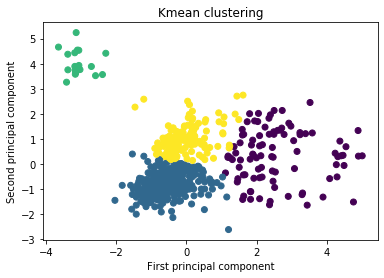

In [15]:
plt.scatter(x=df['first_pc'], y=df['second_pc'], c=df['kmean_group'])
plt.title("Kmean clustering")
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [16]:
# calculate mean values of each group

cluster_group = df.groupby(['kmean_group'])[features].mean()
cluster_group

,pop_density,children_0_14,elders,labor_age,average_household
kmean_group,,,,,
0,35.412118,0.173263,0.192689,0.634048,3.445176
1,3.177698,0.258935,0.156203,0.586104,3.890566
2,2.158500,0.258928,0.407783,0.333288,3.989435
3,4.755034,0.232261,0.271839,0.568338,3.521041


## 5. Visualization on map

In [17]:
!pip install plotly
import json
import plotly.express as px

In [18]:
file = open('Hanoi_new_location.json', encoding='utf8')
geojson = json.load(file)

df['ward_id'] = df['ward_id'].astype('str')
df['kmean_group'] = df['kmean_group'].astype('str')
features = geojson['features']

# Add ward id to geojson
for y in range(len(features)):
    for x in range(len(df.index)):
        if (df.loc[x, 'ward'] == features[y]["properties"]["Name"]) and (df.loc[x, 'district'] == features[y]["properties"]["Quan"]):
            features[y]["id"] = df.loc[x, 'ward_id']

In [ ]:
fig = px.choropleth_mapbox(df, geojson=geojson, locations='ward_id', color='kmean_group',
                           hover_name='ward', center={'lat': 21.0278, 'lon': 105.8342},
                           color_discrete_sequence=px.colors.qualitative.G10,
                           zoom=8)

fig.update_layout(legend=dict(
    yanchor='top', xanchor='left', y=1, x=1, orientation='v'))
fig.update_layout(mapbox_style='carto-positron')
fig.update_layout(width=800, height=600)
fig.update_traces(marker_line=dict(width=1, color='white'))

*The areas that are not colored belong to cluster 1. I tried the code on PyCharm and that area is colored, so I think it is Jupyter Notebook's flaw*